🧠 CD4 Intelligence: Predicting Immunological Risk in HIV Care

 **Problem Statement**
In many low-resource healthcare settings, CD4 count,a critical marker of immune function in HIV patients, is often missing, delayed or inconsistently recorded. This limits timely clinical decision-making and risk stratification. Given the high stakes of immunological decline, there is an urgent need for predictive tools that can estimate CD4 levels and flag patients at risk,even when lab data is unavailable.


**Project Objective**

This project aims to build a machine learning model that:

Imputes missing CD4 values using proxy clinical and demographic features

Predicts CD4 velocity (change over time) for patients with known values

Flags immunological risk using thresholds (e.g., CD4 < 200 or rapid decline)

Deploys a user-friendly dashboard for clinicians to input patient details and receive actionable predictions — even in the absence of lab results

In [ ]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Warnings
import warnings
warnings.filterwarnings('ignore')

UPLOADING DATASET

In [ ]:

df = pd.read_csv('/content/Active on ART Patients Linelist_Aug-2025.csv')
df.head()


,MFL Code,id,Name,CCC No,NUPI,SHA No,Sex,DOB,Age at reporting,Weight,...,Case Manager,NCDs,NCDs Onset Date,NCDs status,AHD Client,Medical cover,Medical cover status,Last risk score,Risk categorization,Evaluation date
0,14123,34,"Wangula, Peter",1412302046,MOH1664624448,NaN,M,28/12/1959,65,60.0,...,NaN,NaN,NaN,NaN,Yes,NaN,NaN,0,Unknown Risk,2025-08-31
1,14123,35,"Opiyo, Eunice",1412302050,MOH1664624384,NaN,F,15/06/1992,33,60.0,...,NaN,NaN,NaN,NaN,Yes,NaN,NaN,0,Unknown Risk,2025-08-31
2,14123,37,"Ouma, Elizabeth",1412302033,MOH1664625093,NaN,F,26/02/1962,63,65.5,...,NaN,NaN,NaN,NaN,No,NaN,NaN,0,Unknown Risk,2025-08-31
3,14123,39,"Juma, Josphine",1412302030,NaN,NaN,F,05/07/1992,33,55.0,...,NaN,NaN,NaN,NaN,No,NaN,NaN,0,Unknown Risk,2025-08-31
4,14123,40,"Omondi, Margaret",1412302027,MOHYQ0WD8LZ9G,NaN,F,01/07/1990,35,47.0,...,NaN,NaN,NaN,NaN,No,NaN,NaN,0,Unknown Risk,2025-08-31


In [ ]:
df.shape

(816, 56)

In [ ]:
df.columns

Index(['MFL Code', 'id', 'Name', 'CCC No', 'NUPI', 'SHA No', 'Sex', 'DOB',
       'Age at reporting', 'Weight', 'Height', 'Blood Pressure',
       'Population Type', 'Date confirmed positive', 'Enrollment Date',
       'Art Start Date', 'First Regimen', 'Current Regimen',
       'Current Regimen Line', 'Baseline CD4', 'Date of Baseline CD4 test',
       'Latest CD4 Result', 'Latest CD4 Result Date', 'Cacx Screening',
       'Cacx Screening Date', 'Last WHO Stage', 'Last WHO Stage Date',
       'Last VL Result', 'VL Validility', 'Last VL Justification',
       'Last VL Date', 'Active in PMTCT', 'Active in OVC', 'Active in OTZ',
       'Active in TB', 'TB screening at last visit', 'TPT Start Date',
       'TPT Outcome', 'TPT Outcome Date', 'Establishment',
       'Differentiated care model', 'Last Visit Date', 'Self Visit Date',
       'Next Appointment Date', 'Months of Prescription', 'Refill Date',
       'Case Manager', 'NCDs', 'NCDs Onset Date', 'NCDs status', 'AHD Client',
       'M

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MFL Code                    816 non-null    int64  
 1   id                          816 non-null    int64  
 2   Name                        816 non-null    object 
 3   CCC No                      816 non-null    int64  
 4   NUPI                        761 non-null    object 
 5   SHA No                      24 non-null     object 
 6   Sex                         816 non-null    object 
 7   DOB                         816 non-null    object 
 8   Age at reporting            816 non-null    int64  
 9   Weight                      816 non-null    float64
 10  Height                      816 non-null    int64  
 11  Blood Pressure              814 non-null    object 
 12  Population Type             816 non-null    object 
 13  Date confirmed positive     816 non

In [ ]:
# Drop columns that are identifiers or have extreme missingness
drop_cols = ['Name', 'CCC No', 'SHA No', 'NUPI', 'Case Manager', 'Medical cover',
             'Medical cover status', 'Evaluation date', 'Date of Baseline CD4 test',
             'Latest CD4 Result Date', 'Baseline CD4', 'Date confirmed positive']

df.drop(columns=drop_cols, inplace=True)


In [ ]:
df.shape

(816, 44)

In [ ]:
# Convert CD4 to numeric and create missing flag
df['Latest CD4 Result'] = pd.to_numeric(df['Latest CD4 Result'], errors='coerce')
df['CD4_Missing'] = df['Latest CD4 Result'].isnull().astype(int)


In [ ]:
# Select features likely to correlate with CD4
features = ['Age at reporting', 'Sex', 'First Regimen', 'Current Regimen', 'Last WHO Stage',
            'Last VL Result', 'Active in TB', 'Differentiated care model', 'Months of Prescription',
            'CD4_Missing']

df_model = df[features + ['Latest CD4 Result']].copy()

In [ ]:
# Impute missing values for categorical and numeric features
cat_cols = df_model.select_dtypes(include='object').columns
num_cols = df_model.select_dtypes(include=['int64', 'float64']).columns.drop('Latest CD4 Result')

# Simple imputation
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='median')

df_model[cat_cols] = imputer_cat.fit_transform(df_model[cat_cols])
df_model[num_cols] = imputer_num.fit_transform(df_model[num_cols])

In [ ]:
# Label encode categorical features
le = LabelEncoder()
for col in cat_cols:
    df_model[col] = le.fit_transform(df_model[col])


EXPLORATORY DATA ANALYSIS

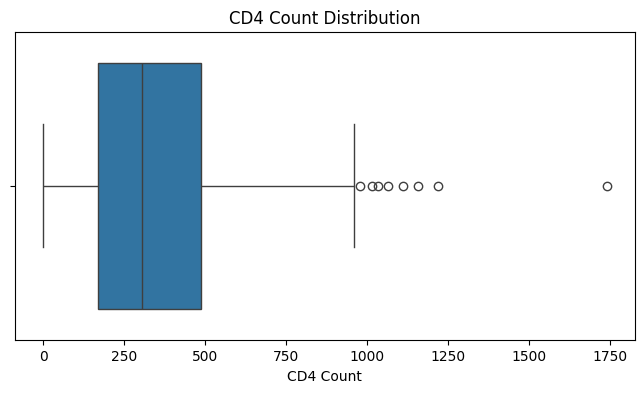

In [ ]:
# Boxplot to visualize CD4 distribution and outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_model['Latest CD4 Result'])
plt.title('CD4 Count Distribution')
plt.xlabel('CD4 Count')
plt.show()


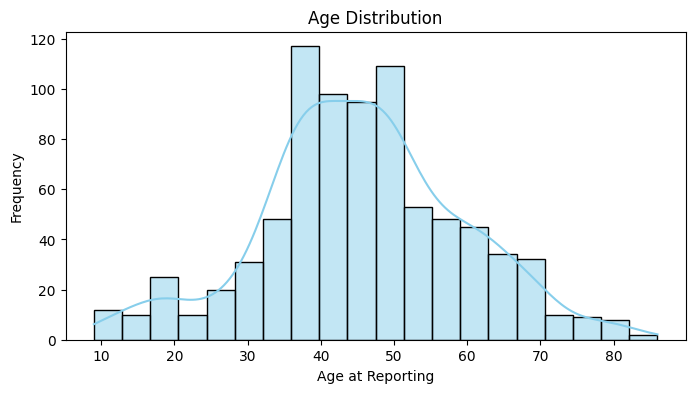

In [ ]:
# Histogram of Age
plt.figure(figsize=(8, 4))
sns.histplot(df_model['Age at reporting'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age at Reporting')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Filter CD4 values between 50 and 1500
df_model = df_model[(df_model['Latest CD4 Result'] >= 50) & (df_model['Latest CD4 Result'] <= 1500)]


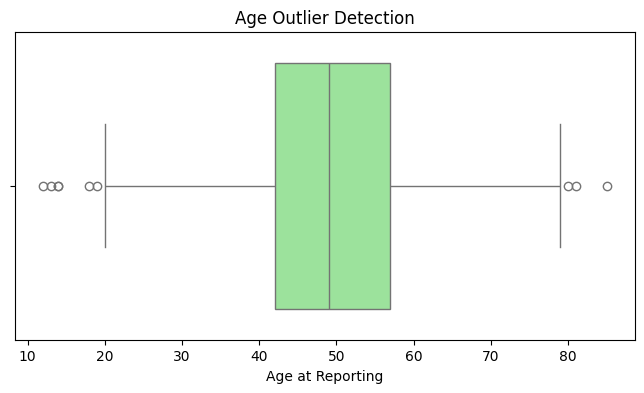

In [ ]:
# Boxplot to detect age outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_model['Age at reporting'], color='lightgreen')
plt.title('Age Outlier Detection')
plt.xlabel('Age at Reporting')
plt.show()


In [ ]:
# Filter age between 15 and 90
df_model = df_model[(df_model['Age at reporting'] >= 15) & (df_model['Age at reporting'] <= 90)]


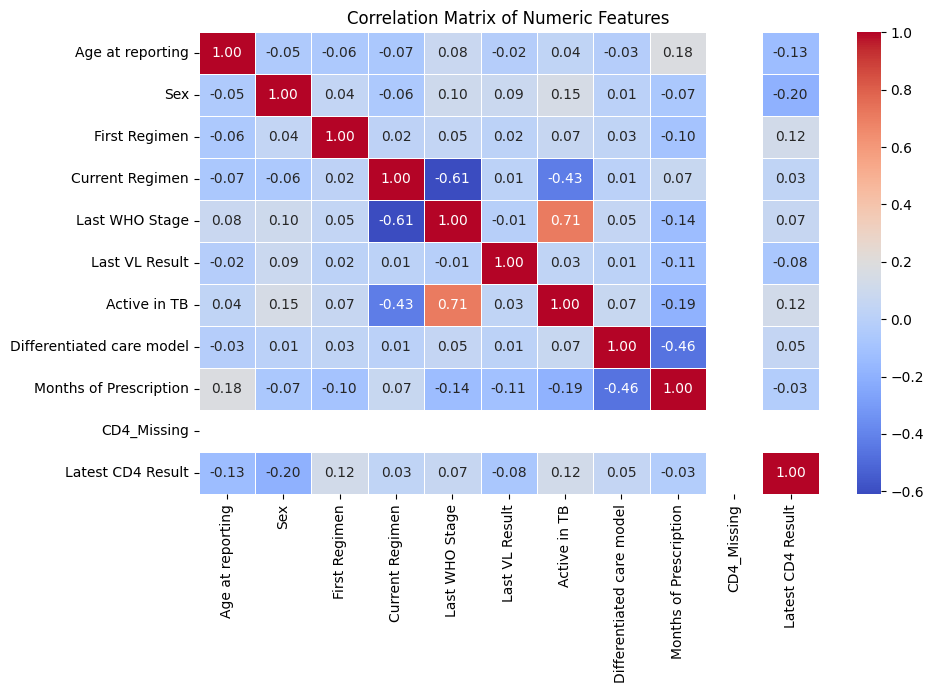

In [ ]:
# Compute correlation matrix for numeric features
corr_matrix = df_model.corr()

# Visualize correlation with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [ ]:
# Check for any remaining missing values
df_model.isnull().sum()

,0
Age at reporting,0
Sex,0
First Regimen,0
Current Regimen,0
Last WHO Stage,0
Last VL Result,0
Active in TB,0
Differentiated care model,0
Months of Prescription,0
CD4_Missing,0


In [ ]:
# Define target and features
y = df_model['Latest CD4 Result']  # Target variable
X = df_model.drop(columns=['Latest CD4 Result'])  # Feature set


In [ ]:
# Print shapes
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (222, 10)
Shape of y: (222,)


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Confirm shapes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (177, 10), (177,)
Test set: (45, 10), (45,)


In [ ]:
# Save cleaned dataset to CSV
df_model.to_csv('/content/cleaned_cd4_dataset.csv', index=False)

# Confirm save
print("Cleaned dataset saved as 'cleaned_cd4_dataset.csv'")

Cleaned dataset saved as 'cleaned_cd4_dataset.csv'


model training

In [ ]:
# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predict CD4 values on the test set
y_pred = xgb_model.predict(X_test)
# View first few predicted CD4 values
print("Predicted CD4 values (first 10):")
print(y_pred[:10])


Predicted CD4 values (first 10):
[188.2996  392.72348 245.42816 320.29843 400.7412  480.06348 692.7952
 336.73907 400.95062 332.86453]


In [ ]:
# Compare predicted vs actual CD4 values
comparison_df = pd.DataFrame({
    'Actual CD4': y_test.values,
    'Predicted CD4': y_pred
})
comparison_df.head(10)


,Actual CD4,Predicted CD4
0,337.0,188.299606
1,88.0,392.723480
2,204.0,245.428162
3,199.0,320.298431
4,466.0,400.741211
5,321.0,480.063477
6,58.0,692.795227
7,346.0,336.739075
8,285.0,400.950623
9,319.0,332.864532


In [ ]:
# Evaluate using regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


RMSE: 235.01
MAE: 176.91
R² Score: -0.59


In [ ]:
# Train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Random Forest Results:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R² Score:", r2_score(y_test, y_pred_rf))


Random Forest Results:
RMSE: 210.80525930861748
MAE: 170.41174444444442
R² Score: -0.27950727967877076


pivoting to classification

In [ ]:
# Create binary risk label: 1 = suppressed, 0 = safe
df_model['CD4_Risk'] = (df_model['Latest CD4 Result'] < 200).astype(int)


In [ ]:
# Define features and target for classification
X_class = df_model.drop(columns=['Latest CD4 Result', 'CD4_Risk'])
y_class = df_model['CD4_Risk']


In [ ]:
# Split classification data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

# Confirm shapes
print(f"Training set: {X_train_c.shape}, {y_train_c.shape}")
print(f"Test set: {X_test_c.shape}, {y_test_c.shape}")


Training set: (177, 10), (177,)
Test set: (45, 10), (45,)


In [ ]:
# Train the classifier
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train_c, y_train_c)


RandomForestClassifier(random_state=42)

In [ ]:
# Predict risk on test set
y_pred_c = clf.predict(X_test_c)

# Evaluate classification performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test_c, y_pred_c))
print("Confusion Matrix:\n", confusion_matrix(y_test_c, y_pred_c))
print("Classification Report:\n", classification_report(y_test_c, y_pred_c))


Accuracy: 0.7111111111111111
Confusion Matrix:
 [[27  6]
 [ 7  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81        33
           1       0.45      0.42      0.43        12

    accuracy                           0.71        45
   macro avg       0.62      0.62      0.62        45
weighted avg       0.70      0.71      0.71        45



In [ ]:
# Install imbalanced-learn if needed
!pip install -q imbalanced-learn

# Import SMOTE
from imblearn.over_sampling import SMOTE

# Apply SMOTE to classification data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_class, y_class)

# Check new class distribution
from collections import Counter
print("Resampled class distribution:", Counter(y_resampled))

Resampled class distribution: Counter({1: 166, 0: 166})


In [ ]:
# Split resampled data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Confirm shapes
print(f"Training set: {X_train_r.shape}, {y_train_r.shape}")
print(f"Test set: {X_test_r.shape}, {y_test_r.shape}")

Training set: (265, 10), (265,)
Test set: (67, 10), (67,)


In [ ]:
# Train classifier on resampled data
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train_r, y_train_r)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict on test set
y_pred_r = rf_clf.predict(X_test_r)

# Evaluate performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test_r, y_pred_r))
print("Confusion Matrix:\n", confusion_matrix(y_test_r, y_pred_r))
print("Classification Report:\n", classification_report(y_test_r, y_pred_r))


Accuracy: 0.835820895522388
Confusion Matrix:
 [[28  3]
 [ 8 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84        31
           1       0.90      0.78      0.84        36

    accuracy                           0.84        67
   macro avg       0.84      0.84      0.84        67
weighted avg       0.85      0.84      0.84        67



In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

# 1. First Regimen encoder
le_first = LabelEncoder()
le_first.fit(df_model['First Regimen'])
joblib.dump(le_first, 'le_first_reg.pkl')

# 2. Current Regimen encoder
le_current = LabelEncoder()
le_current.fit(df_model['Current Regimen'])
joblib.dump(le_current, 'le_current_reg.pkl')

# 3. Differentiated care model encoder
le_care = LabelEncoder()
le_care.fit(df_model['Differentiated care model'])
joblib.dump(le_care, 'le_care.pkl')

# 4. (Re-)Save your trained model
joblib.dump(rf_clf, 'cd4_risk_classifier.pkl')
print("Saved: le_first_reg.pkl, le_current_reg.pkl, le_care.pkl, cd4_risk_classifier.pkl")


Saved: le_first_reg.pkl, le_current_reg.pkl, le_care.pkl, cd4_risk_classifier.pkl


In [ ]:
from google.colab import files
files.download('le_first_reg.pkl')
files.download('le_current_reg.pkl')
files.download('le_care.pkl')
files.download('cd4_risk_classifier.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
# Save the trained classifier
joblib.dump(rf_clf, 'cd4_risk_classifier.pkl')
print("Model saved as 'cd4_risk_classifier.pkl'")


Model saved as 'cd4_risk_classifier.pkl'


In [ ]:
from google.colab import files
files.download('cd4_risk_classifier.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
joblib.dump(rf_clf, 'cd4_risk_classifier.pkl')

['cd4_risk_classifier.pkl']

In [ ]:
df_model.to_csv('cleaned_cd4_dataset.csv', index=False)


In [ ]:
app_code = """
import streamlit as st
import pandas as pd
import joblib

st.markdown("<h1 style='text-align: center; color: teal;'>🧠 CD4 Risk Intelligence Dashboard</h1>", unsafe_allow_html=True)
st.markdown(\"\"\"
<p style='text-align: center; font-size: 16px;'>
Predict immunological suppression in HIV patients using proxy features — even when CD4 lab results are missing.
</p>
\"\"\", unsafe_allow_html=True)

model = joblib.load('cd4_risk_classifier.pkl')

st.sidebar.header("📋 Patient Details")
age = st.sidebar.number_input("🎂 Age at reporting", min_value=0, max_value=120)
sex = st.sidebar.selectbox("⚧️ Sex", ["Male", "Female"])
regimen = st.sidebar.text_input("💊 Current Regimen")
who_stage = st.sidebar.selectbox("🩺 WHO Stage", [1, 2, 3, 4])
vl_result = st.sidebar.number_input("🧪 Last VL Result", min_value=0)
tb_status = st.sidebar.selectbox("🦠 Active in TB", ["Yes", "No"])
months_rx = st.sidebar.number_input("📆 Months of Prescription", min_value=0)
cd4_missing = st.sidebar.selectbox("❓ CD4 Missing", ["Yes", "No"])

input_df = pd.DataFrame({
    'Age at reporting': [age],
    'Sex': [1 if sex == "Male" else 0],
    'Current Regimen': [hash(regimen) % 1000],
    'Last WHO Stage': [who_stage],
    'Last VL Result': [vl_result],
    'Active in TB': [1 if tb_status == "Yes" else 0],
    'Months of Prescription': [months_rx],
    'CD4_Missing': [1 if cd4_missing == "Yes" else 0],
    'First Regimen': [0],  # Placeholder
    'Differentiated care model': [0]  # Placeholder
})

if st.button("🔍 Predict Risk"):
    prediction = model.predict(input_df)[0]
    if prediction == 1:
        st.markdown("<h3 style='color: red;'>⚠️ Immunological Risk: Suppressed (CD4 < 200)</h3>", unsafe_allow_html=True)
    else:
        st.markdown("<h3 style='color: green;'>✅ Immunological Risk: Safe</h3>", unsafe_allow_html=True)

with st.expander("ℹ️ About This Model"):
    st.markdown(\"\"\"
    - **Model Type**: Random Forest Classifier
    - **Accuracy**: 83.6%
    - **Trained on**: ART patient data with proxy features
    - **Balanced using**: SMOTE resampling
    - **Purpose**: Flag suppressed patients when CD4 is missing
    \"\"\")
"""
with open("app.py", "w") as f:
    f.write(app_code)


In [ ]:
requirements = """
streamlit
pandas
scikit-learn
joblib
imbalanced-learn
"""
with open("requirements.txt", "w") as f:
    f.write(requirements)


In [ ]:
from google.colab import files
files.download('cd4_risk_classifier.pkl')
files.download('cleaned_cd4_dataset.csv')
files.download('app.py')
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(X_class.columns.tolist())


['Age at reporting', 'Sex', 'First Regimen', 'Current Regimen', 'Last WHO Stage', 'Last VL Result', 'Active in TB', 'Differentiated care model', 'Months of Prescription', 'CD4_Missing']


<Axes: >

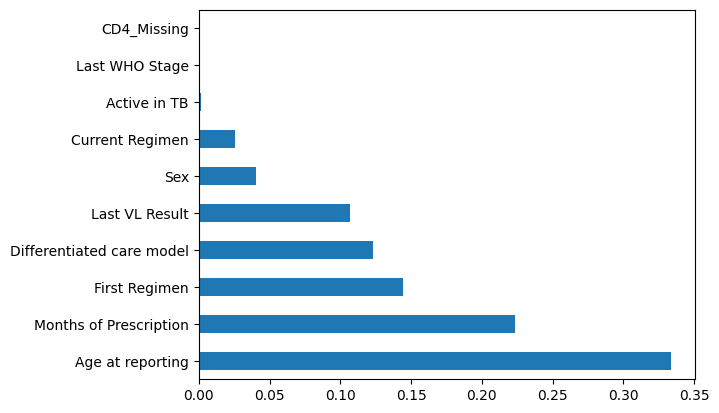

In [ ]:
importances = rf_clf.feature_importances_
pd.Series(importances, index=X_class.columns).sort_values(ascending=False).plot(kind='barh')